<a href="https://colab.research.google.com/github/miltiadiss/CEID_NE577-5G-Architectures-Technologies-Applications-and-Key-Performance-Indicators/blob/main/Code/XGBoost_Regressor_with_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Φόρτωση του τελικού dataset
df = pd.read_csv("/content/drive/MyDrive/final_dataset.csv")

# Ορισμός των χαρακτηριστικών και του στόχου
features = df.columns.difference(["DL_bitrate"])

def create_lagged_features(df, features, num_lags, lag_interval=100):
    df = df.copy()
    for feature in features:
        for lag in range(lag_interval, lag_interval * num_lags + 1, lag_interval):
            df[f"{feature}_lag_{lag}"] = df[feature].shift(lag)
    return df.dropna()

# Ορισμός του εύρους των διαφορετικών αριθμών lags που θα δοκιμαστούν
num_lags_list = [3, 5, 7, 10]

# Ορισμός του Grid για εύρεση των βέλτιστων υπερπαραμέτρων
param_grid = {
    "n_estimators": [200, 300, 400],
    "max_depth": [5, 7, 9],
    "learning_rate": [0.05, 0.1, 0.2],
}

results_list = []

for num_lags in num_lags_list:
    print(f"Testing with {num_lags} lags...")
    df_lagged = create_lagged_features(df, features, num_lags)

    # Ορισμός χαρακτηριστικών εισόδου (X) και στόχου (y)
    X = df_lagged.drop(columns=["DL_bitrate"])
    y = df_lagged["DL_bitrate"]

    # Διαχωρισμός σε Train, Validation και Test Sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Ορισμός XGBoost Regressor
    xgb_regressor = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

    # Χρήση GridSearchCV με 5-Fold Cross Validation
    grid_search = GridSearchCV(
        estimator=xgb_regressor,
        param_grid=param_grid,
        cv=5,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    # Λήψη των καλύτερων υπερπαραμέτρων
    best_params = grid_search.best_params_
    print(f"Best parameters for {num_lags} lags: {best_params}")

    # Εκπαίδευση του XGBoost με τις βέλτιστες παραμέτρους
    best_xgb = xgb.XGBRegressor(**best_params, objective="reg:squarederror", random_state=42)
    best_xgb.fit(X_train, y_train)

    # Πρόβλεψη σε Training, Validation και Test sets
    y_train_pred = best_xgb.predict(X_train)
    y_val_pred = best_xgb.predict(X_val)
    y_test_pred = best_xgb.predict(X_test)

    # Υπολογισμός των μετρικών σφάλματος για όλα τα sets
    results_list.append({
        "num_lags": num_lags,
        "RMSE_Train": np.sqrt(mean_squared_error(y_train, y_train_pred)),
        "RMSE_Validation": np.sqrt(mean_squared_error(y_val, y_val_pred)),
        "RMSE_Test": np.sqrt(mean_squared_error(y_test, y_test_pred)),
        "MAE_Train": mean_absolute_error(y_train, y_train_pred),
        "MAE_Validation": mean_absolute_error(y_val, y_val_pred),
        "MAE_Test": mean_absolute_error(y_test, y_test_pred),
        "MAPE_Train": mean_absolute_percentage_error(y_train, y_train_pred),
        "MAPE_Validation": mean_absolute_percentage_error(y_val, y_val_pred),
        "MAPE_Test": mean_absolute_percentage_error(y_test, y_test_pred),
        "Best_Params": best_params
    })

# Μετατροπή των αποτελεσμάτων σε DataFrame και εμφάνιση
results_df = pd.DataFrame(results_list)
import ace_tools as tools

tools.display_dataframe_to_user(name="Lag Analysis Results", dataframe=results_df)

# Εύρεση του καλύτερου συνδυασμού lags και υπερπαραμέτρων με βάση το χαμηλότερο RMSE Validation
best_result = results_df.loc[results_df["RMSE_Validation"].idxmin()]
print("Best overall combination:")
print(best_result)


Testing with 3 lags...
Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for 3 lags: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 400}
Testing with 5 lags...
Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for 5 lags: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 400}
Testing with 7 lags...
Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Δημιουργία του plot
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Χ άξονας (Train, Validation, Test)
sets = metrics_df["Set"]

# RMSE - Γραμμικό διάγραμμα
ax[0].plot(sets, metrics_df["RMSE"], marker="o", linestyle="-", color="blue", label="RMSE")
ax[0].set_title("Root Mean Squared Error (RMSE)")
ax[0].set_ylabel("RMSE")
ax[0].set_xlabel("Set")
ax[0].grid(True)

# MAE - Γραμμικό διάγραμμα
ax[1].plot(sets, metrics_df["MAE"], marker="s", linestyle="-", color="green", label="MAE")
ax[1].set_title("Mean Absolute Error (MAE)")
ax[1].set_ylabel("MAE")
ax[1].set_xlabel("Set")
ax[1].grid(True)

# MAPE - Γραμμικό διάγραμμα
ax[2].plot(sets, metrics_df["MAPE"], marker="^", linestyle="-", color="red", label="MAPE")
ax[2].set_title("Mean Absolute Percentage Error (MAPE)")
ax[2].set_ylabel("MAPE")
ax[2].set_xlabel("Set")
ax[2].grid(True)

# Προσαρμογή της διάταξης
plt.tight_layout()
plt.show()

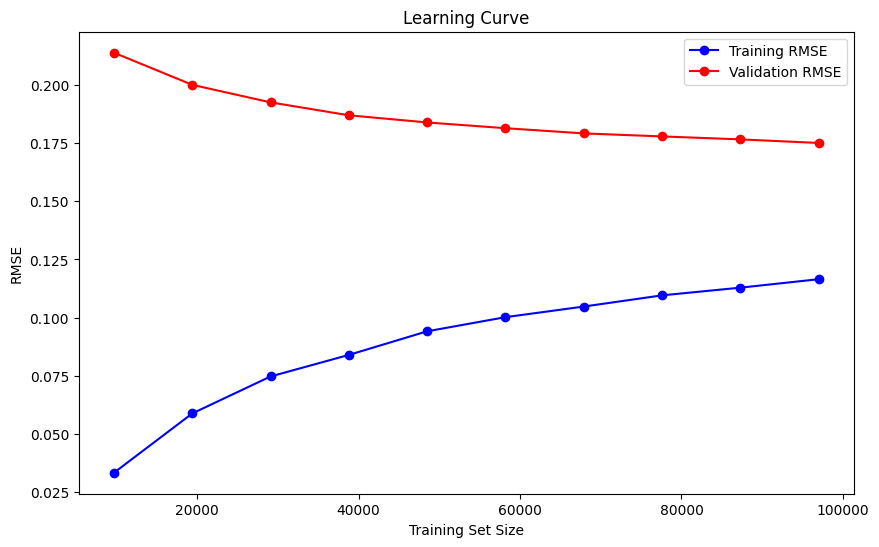

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_xgb, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error", train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = -train_scores.mean(axis=1)
val_scores_mean = -val_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, "o-", color="blue", label="Training RMSE")
plt.plot(train_sizes, val_scores_mean, "o-", color="red", label="Validation RMSE")
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.title("Learning Curve")
plt.legend()
plt.show()